### **Initialization**
* I use these 3 lines of code on top of my each notebook because it won't cause any trouble while reloading or reworking on the Project or Problem. And the third line of code helps to make visualization within the Notebook.

In [1]:
# Initialization
# I use these 3 lines of code on top of my each Notebooks
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Downloading the Dependencies**
* I prefer to download all necessary Libraries and Dependencies on one particular cell which mainly focus on Libraries and Dependencies.

In [2]:
# Downloading all necessary Libraries and Dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import csv

**Getting the Data**
* I am using Google Colab for this Project, so the act of reading the Data might be different from different platforms. I have used the link below to download the full data of [Sunspots](https://www.kaggle.com/robervalt/sunspots). You can manually download the Data from [Kaggle](https://www.kaggle.com/robervalt/sunspots) as well.

In [3]:
# Loading the Data 
# Using Google Colab for loading the data
# Uncomment the line below
#!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-08-18 08:02:04--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.198.128, 173.194.74.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.198.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-08-18 08:02:04 (66.4 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



**Writing Functions**
* All the functions required for this Project which can be written manually are defined in the cell below. For better convenience, it is kept in one single cell.

In [4]:
# For plotting the series or data
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

# For preparing the dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

# For forecasting the accuracy of the model
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

**Processing the Data**
* Opening the csv file and accessing the time and average sunspots from data.

In [5]:
# Processing and Preparing the Data
time_step = []
sunspots = []

with open("/tmp/sunspots.csv") as csvfile:
  reader = csv.reader(csvfile, delimiter=",")
  
  # First line is the header, so skipping.
  next(reader)

  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Changing into array using numpy
series = np.array(sunspots)
time = np.array(time_step)

**Looking at the Data**

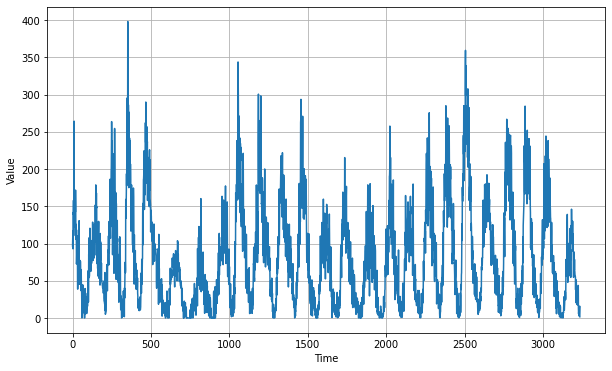

In [6]:
# Looking at the Data
plt.figure(figsize=(10, 6))
plot_series(time, series)

### **Preparing the Model**


**Adjusting the Dependencies**

In [7]:
# Adjusting the parameters & preparing the Model
split = 3000
window_size= 30
batch_size = 32
shuffle_buffer_zone = 1000

# Training data
train_time = time[:split]
X_train = series[:split]
# Validation data
valid_time = time[split:]
X_valid = series[split:]

### **Neural Network**
* Preparing the Deep Neural Network.

In [8]:
# Clearing the depending variables if there are any.
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 64
batch_size = 256

# Preparing the data with function defined above
train = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_zone)
print(train);
X_train.shape

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


(3000,)

In [10]:
# Preparing the model (DNN)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                                                           padding="causal",
                                                           activation="relu",
                                                           input_shape=[None, 1]),
                                    tf.keras.layers.LSTM(64, return_sequences=True),
                                    tf.keras.layers.LSTM(128, return_sequences=True),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 400)

])

# Preparing the Dependencies
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-07 * 10**(epoch/20) 
)

optimizer = tf.keras.optimizers.SGD(lr=1e-07, momentum=0.9)

# Compiling the Model
model.compile(loss = tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Fitting the Model
history = model.fit(train, epochs=50, callbacks=[lr_schedule])

Epoch 1/50
12/12 [==============================] - 1s 43ms/step - loss: 114.6601 - mae: 115.1594
Epoch 2/50
12/12 [==============================] - 1s 51ms/step - loss: 88.4148 - mae: 88.9138
Epoch 3/50
12/12 [==============================] - 1s 52ms/step - loss: 65.4476 - mae: 65.9457
Epoch 4/50
12/12 [==============================] - 1s 54ms/step - loss: 52.1421 - mae: 52.6398
Epoch 5/50
12/12 [==============================] - 1s 51ms/step - loss: 47.1493 - mae: 47.6469
Epoch 6/50
12/12 [==============================] - 1s 52ms/step - loss: 41.1711 - mae: 41.6683
Epoch 7/50
12/12 [==============================] - 1s 55ms/step - loss: 37.6903 - mae: 38.1867
Epoch 8/50
12/12 [==============================] - 1s 55ms/step - loss: 35.8653 - mae: 36.3611
Epoch 9/50
12/12 [==============================] - 1s 54ms/step - loss: 34.6610 - mae: 35.1569
Epoch 10/50
12/12 [==============================] - 1s 54ms/step - loss: 33.3148 - mae: 33.8106
Epoch 11/50
12/12 [==================

**Observing the Learning rate**

(1e-08, 0.0001, 0.0, 60.0)

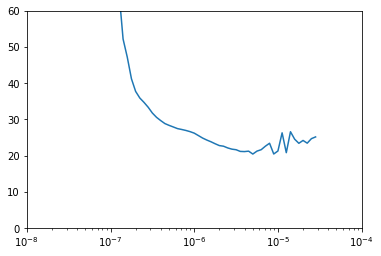

In [12]:
# Plotting the learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-08, 1e-04, 0, 60])

**Preparing the Deep Neural Network**

In [18]:
# Clearing the depending variables if there are any.
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 60
batch_size = 100


# Preparing the data with function defined above
train = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_zone)

# Preparing the model (DNN)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                                                           padding="causal",
                                                           activation="relu",
                                                           input_shape=[None, 1]),
                                    tf.keras.layers.LSTM(128, return_sequences=True),
                                    tf.keras.layers.LSTM(128, return_sequences=True),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 400)

])

# Preparing the Dependencies
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-05 * 10**(epoch/400) 
)

optimizer = tf.keras.optimizers.SGD(lr=1e-05, momentum=0.9)

# Compiling the Model
model.compile(loss = tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Fitting the Model
history = model.fit(train, epochs=50, callbacks=[lr_schedule])

Epoch 1/50
30/30 [==============================] - 1s 43ms/step - loss: 39.2353 - mae: 39.7313
Epoch 2/50
30/30 [==============================] - 1s 38ms/step - loss: 20.9650 - mae: 21.4587
Epoch 3/50
30/30 [==============================] - 1s 38ms/step - loss: 19.2788 - mae: 19.7716
Epoch 4/50
30/30 [==============================] - 1s 38ms/step - loss: 18.6409 - mae: 19.1331
Epoch 5/50
30/30 [==============================] - 1s 35ms/step - loss: 18.0872 - mae: 18.5791
Epoch 6/50
30/30 [==============================] - 1s 34ms/step - loss: 17.7008 - mae: 18.1923
Epoch 7/50
30/30 [==============================] - 1s 35ms/step - loss: 17.6450 - mae: 18.1365
Epoch 8/50
30/30 [==============================] - 1s 34ms/step - loss: 17.5107 - mae: 18.0023
Epoch 9/50
30/30 [==============================] - 1s 34ms/step - loss: 17.8171 - mae: 18.3086
Epoch 10/50
30/30 [==============================] - 1s 34ms/step - loss: 17.3985 - mae: 17.8895
Epoch 11/50
30/30 [====================

**Forecasting with Model**


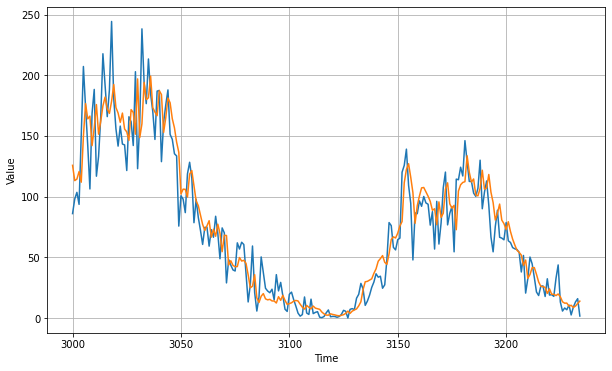

In [22]:
# Forecasting with model
forecast = model_forecast(model, series[..., np.newaxis], window_size)
forecast = forecast[split - window_size:-1, -1, 0]

# Plotting the Forecasting
plt.figure(figsize=(10, 6))
plot_series(valid_time, X_valid)
plot_series(valid_time, forecast)

In [23]:
# Calculating the mean squared error
tf.keras.metrics.mean_absolute_error(X_valid, forecast).numpy()

14.106373

**Observing the Model**


<Figure size 432x288 with 0 Axes>

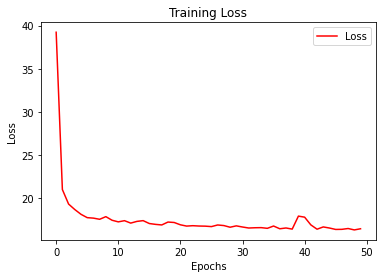

<Figure size 432x288 with 0 Axes>

In [25]:
# Retrieving the list of results
loss = history.history["loss"]
epochs = range(len(loss))

# Plotting Training and Validation loss per epoch
plt.plot(epochs, loss, "r")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()